# Instrument visualisation

RAMP contains a simple matplotlib interface for instrument visualisation. This can be used for debugging instrument definition files, and checking that components possess the correct orientation.

In [1]:
import mcramp as mcr
import pyopencl as cl
import numpy as np

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

## Basic visualisation

The simplest possible instrument visualisation is carried out using the ``visualise()`` member function of the RAMP instrument class. For demonstration, we will load the simplified power spectrometer instrument used elsewhere in the documentation.

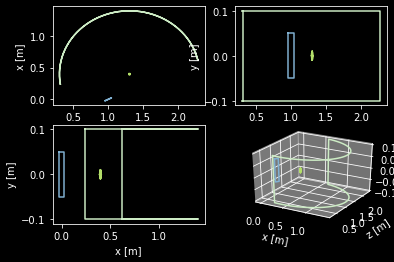

In [6]:
inst = mcr.Instrument(
    'powder.json', 
    ctx, 
    queue, 
    Ei=9.09, 
    Mono_angle=0.46, 
    detector_binning=[0, 0.1, 1] # Dummy values - not used in current demo
)
inst.visualise(controls=False)

This basic visualisation contains 4 projects of the instrument: 3 orthogonal and 1 three dimensional projection. These plots have the usual matplotlib interactivity supported by the environment in which they are being run.

## Visualisation controls

The ``visualise()`` command takes a Boolean argument called ``controls``. When ``controls`` is ``True`` (NOTE: this is the default value for ``controls``!), matplotlib will attempt to provide interactive controls for the plots. Depending on this environment, this may not be possible (a prominent example being Google Colab, which does not support the required matplotlib Jupyter widgets).

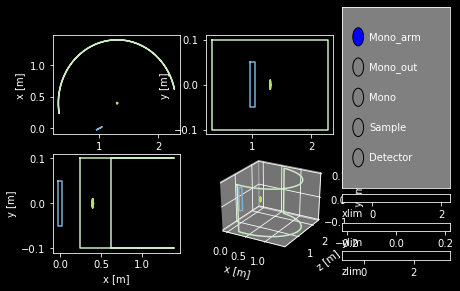

In [15]:
inst.visualise(controls=True)

In the case of the notebook platform I am currently writing on, this is not available as it is not supported by the documentation engine! However, there is support for interactive matplotlib widgets in locally executed Jupyter/IPython notebooks (left as an exercise to the reader). Executing RAMP scripts on a native Python installation with matplotlib installed should support these interactive widgets.

In lieu of the availability of interactive controls, there are several parameters for the ``visualise()`` command to control the plots.

 - ``[x/y/z]lim`` controls the limits of the ``[x/y/z]`` axis of every plot, suupplied as a 2-tuple or 2 element list.
 - ``focus`` is the name of a component in the instrument definition file upon which the visualisation will be centered. The zero of the plot axes will be changed to the position of the focused component, and the axis limits will be adjusted such that by default only the region of the instrument close to the focussed component is in view.

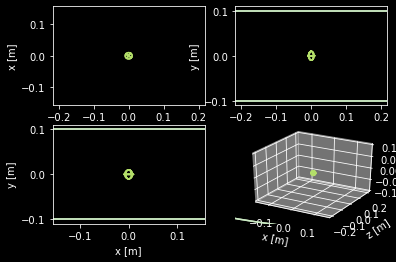

In [17]:
inst.visualise(controls=False, focus='Sample')

Finally, any additional keyword arguments supplied to ``visualise()`` other than those listed above will be given to the ``matplotlib.pyplot.figure()`` call which instantiates the plot. This can be used to control several plotting parameters, e.g. the figure size.

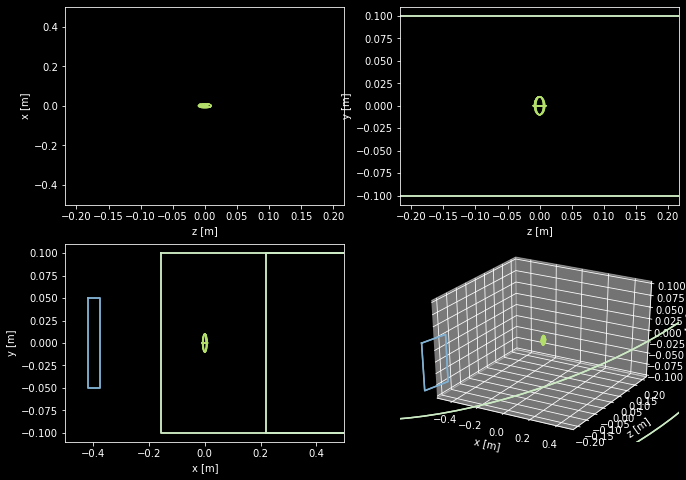

In [18]:
inst.visualise(controls=False, focus='Sample', xlim=[-0.5, 0.5], figsize=(11, 8))